Test Loss (MSE): 764795840.0
R² Score: 0.8518449068069458


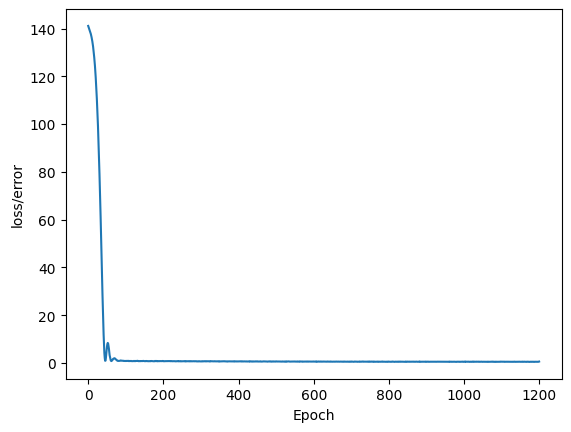

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the improved Model class with Leaky ReLU activation
class ImprovedModel(nn.Module):
    def __init__(self, in_features=80, h1=256, h2=128, h3=64, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
        self.dropout = nn.Dropout(0.1)  # Dropout layer for regularization

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)  # Apply dropout after first layer
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout(x)  # Apply dropout after second layer
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        x = self.out(x)
        return x

# Load the dataset
df = pd.read_csv("train.csv")

# Impute missing values
median_value = df["LotFrontage"].median()
df["LotFrontage"] = df["LotFrontage"].fillna(median_value)
categorical_cols = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", 
                    "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", 
                    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
                    "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", 
                    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                    "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual",
                    "Functional", "FireplaceQu", "GarageType", "GarageFinish",
                    "GarageQual", "GarageCond", "PavedDrive", "PoolQC",
                    "Fence", "MiscFeature", "SaleType", "SaleCondition"]
df[categorical_cols] = df[categorical_cols].fillna("None")
numerical_cols = ["GarageYrBlt", "GarageCars", "GarageArea", "MasVnrArea"]
df[numerical_cols] = df[numerical_cols].fillna(0)

# Convert categorical features to numeric using one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols)

# Apply log transformation to the target variable
df["SalePrice"] = np.log1p(df["SalePrice"])

# Scale features
scaler = MinMaxScaler()
train_features = df.drop(columns=["SalePrice"])
train_scaled = scaler.fit_transform(train_features)
df_scaled = pd.DataFrame(train_scaled, columns=train_features.columns)

import joblib

# Save the scaler and column template
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(train_features.columns.tolist(), 'columns_template.pkl')

# Train-Test Split
X = df_scaled.values
y = df["SalePrice"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure target size matches input size
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure target size matches input size

# Initialize model, criterion and optimizer
torch.manual_seed(41)
model = ImprovedModel(in_features=X_train.shape[1], h1=128, h2=64, h3=32, out_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)

# Train the model
epochs = 1200
losses = []
for i in range(epochs):
    model.train()  # Set the model to training mode
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the model on test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_predictions_log = model(X_test.clone().detach())

# Convert log predictions back to original scale
test_predictions = np.expm1(test_predictions_log.numpy())
y_test_original = np.expm1(y_test.numpy())

# Calculate metrics
mse = mean_squared_error(y_test_original, test_predictions)
r2 = r2_score(y_test_original, test_predictions)

print(f"Test Loss (MSE): {mse}")
print(f"R² Score: {r2}")

# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.show()

In [26]:
rmse = np.sqrt(mse)
print("RMSE:", rmse)


RMSE: 27654.94241541645


In [27]:
print("Mean Sale Price (in $):", y_test_original.mean())
# If it's still a tensor:
print("Mean Sale Price (in $):", y_test_original.mean().item())



Mean Sale Price (in $): 181574.05
Mean Sale Price (in $): 181574.046875


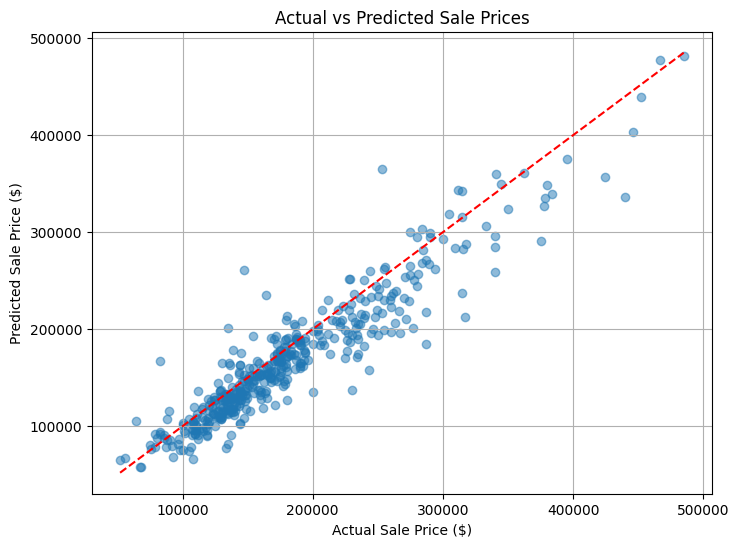

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, test_predictions, alpha=0.5)
plt.xlabel("Actual Sale Price ($)")
plt.ylabel("Predicted Sale Price ($)")
plt.title("Actual vs Predicted Sale Prices")
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)],
         color='red', linestyle='--')  # Line of perfect prediction
plt.grid(True)
plt.show()

In [29]:
# Save our NN Model
# Save the model
torch.save(model.state_dict(), 'my_really_awesome_housing_model.pt')

In [30]:
# Load the Saved Model
new_model = ImprovedModel(in_features=304, h1=128, h2=64, h3=32, out_features=1)

# Check if the file exists and load the model state dictionary
import os

model_path = 'my_really_awesome_housing_model.pt'
if os.path.exists(model_path):
    new_model.load_state_dict(torch.load(model_path))
    new_model.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model file '{model_path}' not found.")

# Example input tensor 
example_input = torch.tensor([[0.5] * 80], dtype=torch.float32)


Model loaded successfully.


In [ ]:
# seeing the results for 10 random datapoints using original code

In [5]:
import pandas as pd
import numpy as np
import torch
import joblib

#  Load the Excel file
df_input = pd.read_excel("Book1.xlsx")  

#  Separate features and actual prices (if available)
actual_prices = df_input["SalePrice"] if "SalePrice" in df_input.columns else None
features_df = df_input.drop(columns=["SalePrice"], errors="ignore")

#  Fill missing values
features_df["LotFrontage"] = features_df["LotFrontage"].fillna(70.0)  # Use training median
for col in features_df.select_dtypes(include='object').columns:
    features_df[col] = features_df[col].fillna("None")
for col in features_df.select_dtypes(include='number').columns:
    features_df[col] = features_df[col].fillna(0)

#  One-hot encode and align with training columns
df_encoded = pd.get_dummies(features_df)

# Load column template and scaler
columns_template = joblib.load("columns_template.pkl")
scaler = joblib.load("scaler.pkl")

# Reindex to match training columns
df_encoded = df_encoded.reindex(columns=columns_template, fill_value=0)

#  Scale the input
scaled_array = scaler.transform(df_encoded)
input_tensor = torch.tensor(scaled_array, dtype=torch.float32)

#  Define the model architecture
class ImprovedModel(torch.nn.Module):
    def __init__(self, in_features, h1, h2, h3, out_features):
        super(ImprovedModel, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, h1)
        self.fc2 = torch.nn.Linear(h1, h2)
        self.fc3 = torch.nn.Linear(h2, h3)
        self.out = torch.nn.Linear(h3, out_features)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc3(x), negative_slope=0.01)
        return self.out(x)

#  Load the trained model
model = ImprovedModel(in_features=304, h1=128, h2=64, h3=32, out_features=1)
model.load_state_dict(torch.load("my_really_awesome_housing_model.pt"))
model.eval()

#  Make predictions
with torch.no_grad():
    log_preds = model(input_tensor).squeeze().numpy()
    predicted_prices = np.expm1(log_preds)

#  Create a results DataFrame
results_df = pd.DataFrame({
    "PredictedPrice": predicted_prices
})

if actual_prices is not None:
    results_df["ActualPrice"] = actual_prices.values
    results_df["Error"] = results_df["PredictedPrice"] - results_df["ActualPrice"]
    results_df["ErrorPercent"] = 100 * results_df["Error"] / results_df["ActualPrice"]

#  Display results
print(results_df.round(2))

    PredictedPrice  ActualPrice     Error  ErrorPercent
0     90017.382812       129500 -39482.62        -30.49
1    306810.375000       345000 -38189.62        -11.07
2     95628.257812       144000 -48371.74        -33.59
3    183592.015625       279500 -95907.98        -34.31
4    110101.406250       157000 -46898.59        -29.87
5    114138.523438       132000 -17861.48        -13.53
6    123207.687500       149000 -25792.31        -17.31
7     80201.562500        90000  -9798.44        -10.89
8    123192.648438       159000 -35807.35        -22.52
9     91507.203125       139000 -47492.80        -34.17
10   284333.093750       325300 -40966.91        -12.59
11    93903.460938       139400 -45496.54        -32.64
12   173919.203125       230000 -56080.80        -24.38
13    98658.398438       129900 -31241.60        -24.05
14   123869.343750       154000 -30130.66        -19.57
15   208199.093750       256300 -48100.91        -18.77
16   109782.656250       134800 -25017.34       